In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pandas as pd

import sys
sys.path.append("../../") # go to parent dir so we can import `speech2phone`
from speech2phone.preprocessing import Preprocess

# Load data

In [2]:
X, y = Preprocess.get_data(preprocessor=Preprocess.mel, batch_preprocess=False, TIMIT_root='../TIMIT/TIMIT', max_files=100)
X, y = np.array(X), np.array(y)
is_nan = np.isnan(X).any(axis=1)
X, y = X[~is_nan], y[~is_nan]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("done")

num_files: 4620
done


../../speech2phone/preprocessing/preprocessing.py:115: RuntimeWarning: divide by zero encountered in log
  spectrum = np.log(np.abs(sp.fft(X))[:len(X)//2])
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:2259: RuntimeWarning: invalid value encountered in true_divide
  Y[tuple(sl)] /= 2  # halve the component at -N/2
/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:2264: RuntimeWarning: invalid value encountered in multiply
  y = fftpack.ifft(Y, axis=axis) * (float(num) / float(Nx))


In [3]:
# sys.path

# Random Forest

In [4]:
rf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.3651877133105802

# XGBoost

In [5]:
# Converts our y "string" data to categorical data, necessary for XGBoost and PCA
y_df = pd.DataFrame(y)
y_df[0] = y_df[0].astype('category')
y_ = y_df[0].values.codes
y = y_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {"max_depth": 20, 
          "eta": 0.3, 
          "num_class": 61, 
          "gamma": 1, 
          "lambda": 10, 
          "alpha": 10}
params["objective"] = "multi:softmax"
params["eval_metric"] = "merror"
params['nthread'] = 4
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [7]:
# This cell doesn't do anything for me, just hangs. Any luck for anyone else?

# num_round = 1
# bst = xgb.train(params, dtrain, num_round, evallist)
# y_pred = bst.predict(dtest)
# score = sum(y_pred == y_test) / len(y_test)
# print(score)

# PCA

In [8]:
class PCA:
    def __init__(self, X, y=None, s=None, sparse=False, center=True):
        self.X = X - X.mean(axis=0) if center else X
        self.y = y
        self.sparse = sparse
        if s == None:
            n, d = X.shape
            s = d
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            self.y_dict = {}
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def update_s(self, s):
        if not self.sparse:
            U, sig, Vh = la.svd(self.X, full_matrices=False)
            self.sig = sig[:s]**2
            self.Vh = Vh[:s]
        else:
            _, sig, Vh = spla.svds(self.X, k=s, return_singular_vectors="vh")
            self.sig = sig**2
            self.Vh = Vh
        self.a = self.transform(self.X)
        self.proj_X = self.project(self.X)
        if type(self.y) != None:
            A = np.vstack([self.a, self.y])
            for yj in np.unique(self.y):
                curr_a = A.T[A[s] == yj][:, :s]
                if len(curr_a) != 0:
                    self.y_dict[yj] = curr_a.mean(axis=0)
    
    def transform(self, x):
        return self.Vh@x.T
    
    def project(self, x):
        return self.Vh.T@self.a
    
    def predict(self, x):
        a_test = self.Vh @ x.T
        predicted = []
        for a in a_test.T:
            similarities = []
            for key, value in self.y_dict.items():
                similarity = np.dot(a, value) / (la.norm(a)*la.norm(value))
                similarities.append((similarity, key))
            predicted.append(max(similarities, key=lambda x: x[0])[1])
        return predicted

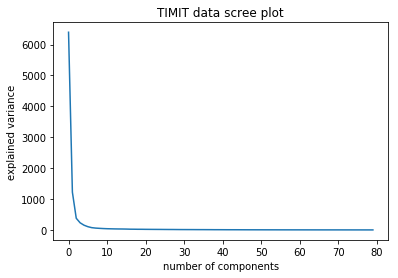

In [9]:
pca_timit = PCA(X, y=y)
n, d = X.shape
fig = plt.figure()
plt.plot(np.arange(d), pca_timit.sig)
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.title("TIMIT data scree plot")
plt.show()
# print(pca_timit.sig / pca_timit.sig.sum())
i = 1
p = 0
while p < .9:
    p = np.sum(pca_timit.sig[:i]) / np.sum(pca_timit.sig)
#     print(i, p)
    i+=1

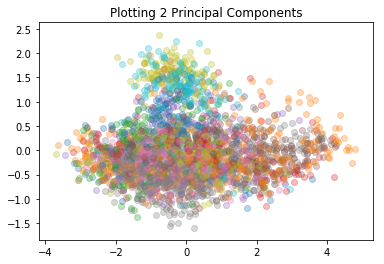

In [10]:
pca_timit.update_s(2)
A = np.vstack([pca_timit.a, pca_timit.y])
for i in np.unique(y):
    curr_a = A.T[A[2] == i][:, :2]
    plt.scatter(curr_a[:, 0], curr_a[:, 1], alpha=0.3)
plt.title("Plotting 2 Principal Components")
plt.show()

In [11]:
pca_train = PCA(X_train, y=y_train, s=20, center=False)
y_pred = pca_train.predict(X_test)
pca_score = sum(y_pred == y_test) / len(y_test)
print("PCA accuracy: {:.3f}".format(pca_score))

PCA accuracy: 0.226
